In [3]:
import io
from PIL import Image
from pathlib import Path
import os
import torch
from sklearn.manifold import TSNE
import pickle
import numpy as np
import matplotlib.pyplot as plt
os.environ['HF_HOME'] = '/vol/biomedic3/bglocker/ugproj2324/nns20/CheXagent/.cache' ## THIS HAS TO BE BEFORE YOU IMPORT TRANSFORMERS
from transformers import AutoProcessor, AutoModelForCausalLM, GenerationConfig

/vol/biomedic3/bglocker/ugproj2324/nns20/CheXagent/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def setup_model() -> tuple:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float16

    processor = AutoProcessor.from_pretrained("StanfordAIMI/CheXagent-8b", trust_remote_code=True)
    generation_config = GenerationConfig.from_pretrained("StanfordAIMI/CheXagent-8b")
    model = AutoModelForCausalLM.from_pretrained(
        "StanfordAIMI/CheXagent-8b", torch_dtype=dtype, trust_remote_code=True
    ).to(device)

    return processor, model, device, dtype, generation_config

processor, model, device, dtype, generation_config = setup_model()

Loading checkpoint shards: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


In [3]:
# print(model.__dict__.keys())
print(model.__dict__["_modules"].keys())
print(model.language_model.model.norm)
print(model.language_model.lm_head)

odict_keys(['vision_model', 'qformer', 'language_projection', 'language_model'])
MistralRMSNorm()
Linear(in_features=4096, out_features=32000, bias=False)


In [1]:
patch_embeddings_outputs = []

def patch_embedding_hook(module, input, output):
    """Function to be called by the hook for the patch embeddings layer."""
    print("\n\nPatch Embedding Hook")
    patch_embeddings_outputs.append(output.cpu().detach())  # Assuming you want to move data to CPU for analysis

post_layer_norm_outputs = []

def post_layer_norm_hook(module, input, output):
    """Function to be called by the hook for the post layer norm layer."""
    print("\nPost Layer Norm Hook")
    print("output shape: ", output.shape)
    post_layer_norm_outputs.append(output.cpu().detach())  # Assuming you want to move data to CPU for analysis

q_former_outputs = []
language_projection_outputs = []

def language_projection_hook(module, input, output):
    """Function to be called by the hook for the language projection layer."""
    print("\nLanguage Projection Hook")
    print("Input shape: ", input[0].shape)
    q_former_outputs.append(input[0].cpu().detach())  # Assuming you want to move data to CPU for analysis
    print("Output shape: ", output.shape)
    language_projection_outputs.append(output.cpu().detach())  # Assuming you want to move data to CPU for analysis

mistral_model_outputs = []

def mistral_model_output_hook(module, input, output):
    """Function to be called by the hook for the mistral norm layer."""
    print("\nMistral Model Output Hook")
    print("Output shape: ", output.shape)
    mistral_model_outputs.append(output.cpu().detach())  # Assuming you want to move data to CPU for analysis

In [4]:
sample_image_0 = Path('/vol/biodata/data/chest_xray/mimic-cxr-jpg/files/p10/p10002428/s59891001/df59ff50-56f1fd83-f3664b8b-8e2c67dd-d5f0d039.jpg')
sample_image_1= Path('/vol/biodata/data/chest_xray/VinDr-CXR/1.0.0_png_512/raw/test/bfd1974dc9778aadb407a11b57ab748f.png')
sample_image_2 = Path('/vol/biodata/data/chest_xray/VinDr-CXR/1.0.0_png_512/raw/test/39949d5d2d8855e391b87d8a932b5aaf.png')
sample_images = [sample_image_0, sample_image_1, sample_image_2]

NameError: name 'Path' is not defined

In [2]:
# images = [Image.open(sample_image_0).convert("RGB"), Image.open(sample_image).convert("RGB"), Image.open(sample_image_2).convert("RGB")]

def generate_with_forward_hooks(images, prompt, processor, model, device, dtype, generation_config):
    
    # register hooks
    patch_embeddings = model.vision_model.embeddings.patch_embedding.register_forward_hook(patch_embedding_hook)
    post_layer_norm = model.vision_model.post_layernorm.register_forward_hook(post_layer_norm_hook)
    language_projection = model.language_projection.register_forward_hook(language_projection_hook)
    mistral_model = model.language_model.model.norm.register_forward_hook(mistral_model_output_hook)

    # complete a forward pass 
    inputs = processor(
        images=images, text=f" USER: <s>{prompt} ASSISTANT: <s>", return_tensors="pt"
    ).to(device=device, dtype=dtype)
    output = model.generate(**inputs, generation_config=generation_config)[0]
    response = processor.tokenizer.decode(output, skip_special_tokens=True)

    # remove hooks
    patch_embeddings.remove()
    post_layer_norm.remove()
    language_projection.remove()
    mistral_model.remove()

    return response

prompt = "Describe the findings"
for image in sample_images:
    image = Image.open(image).convert("RGB")
    response = generate_with_forward_hooks(image, prompt, processor, model, device, dtype, generation_config)
    print(response)

NameError: name 'sample_images' is not defined

In [36]:
print(len(q_former_outputs))
print(f"shape of each q_former output: {q_former_outputs[0].shape}")

3
shape of each q_former output: torch.Size([1, 128, 768])


In [38]:
q_former_outputs_flattened = [output.flatten() for output in q_former_outputs]
print(f"shape of flattened q_former output: {q_former_outputs_flattened[0].shape}")

shape of flattened q_former output: torch.Size([98304])


In [40]:
# construct a 2D numpy array from the flattened q_former outputs
q_former_outputs_np = np.array(q_former_outputs_flattened)
print(f"shape of q_former outputs numpy array: {q_former_outputs_np.shape}")

shape of q_former outputs numpy array: (3, 98304)


In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
q_former_outputs_pca = pca.fit_transform(q_former_outputs_np)
print(q_former_outputs_pca.shape)

(3, 3)


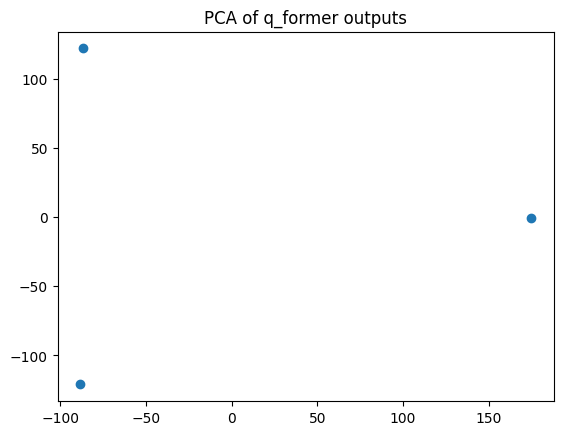

In [45]:
# plot the PCA of the q_former outputs
plt.scatter(q_former_outputs_pca[:, 0], q_former_outputs_pca[:, 1])
plt.title("PCA of q_former outputs")
plt.show()

In [28]:

if all(torch.equal(patch_embeddings_outputs[0], output) for output in patch_embeddings_outputs):
    print(f"All {len(patch_embeddings_outputs)} outputs are the same")
    patch_embeddings_outputs = patch_embeddings_outputs[:1]
else:
    print(f"Outputs are different")
    print(len(patch_embeddings_outputs))
print(patch_embeddings_outputs[0].shape) # the extra dimension supports multiple input images

# flatten the patch embeddings from (batch_size, embedding_dim, feature map width, feature map height) to (batch_size,feature map height * feature map width ,embedding_dim)
patch_embeddings_flattened = patch_embeddings_outputs[0].reshape(patch_embeddings_outputs[0].shape[0],patch_embeddings_outputs[0].shape[1],-1)
print(f"{patch_embeddings_flattened.shape=}")

# apply PCA to reduce the dimensionality of the patch embeddings
pca = PCA(n_components=100)
patch_embeddings_pca = pca.fit_transform(patch_embeddings_flattened[0].T)
print(patch_embeddings_pca.shape)



Outputs are different
4
torch.Size([1, 1408, 32, 32])
patch_embeddings_flattened.shape=torch.Size([1, 1408, 1024])
(1024, 100)


In [41]:
from scipy.stats import entropy
patch_embeddings_flattened = patch_embeddings_outputs[0].view(-1, patch_embeddings_outputs[0].shape[1])
# normalize the patch embeddings so that they are in the range [0,1]
patch_embeddings_normalized = (patch_embeddings_flattened - patch_embeddings_flattened.min()) / (patch_embeddings_flattened.max() - patch_embeddings_flattened.min())
# calculate the entropy of each patch embedding
patch_embeddings_entropy = entropy(patch_embeddings_normalized.T)
# sort the entropy values and print the sorted values not the indices
print(np.sort(patch_embeddings_entropy))

[7.2358694 7.2385015 7.243475  ... 7.2517977 7.251814  7.2522326]


In [37]:
if all(torch.equal(post_layer_norm_outputs[0], output) for output in post_layer_norm_outputs):
    print(f"All {len(post_layer_norm_outputs)} outputs are the same")
    post_layer_norm_outputs = post_layer_norm_outputs[:1]
else:
    print(f"Outputs are different")
    print(len(post_layer_norm_outputs))
print(post_layer_norm_outputs[0].shape)
print(post_layer_norm_outputs[1].shape)

# compare all 1025 elements of post_layer_norm_outputs[0] with post_layer_norm_outputs[1]
for i in range(1025):
    if torch.equal(post_layer_norm_outputs[0][0][i], post_layer_norm_outputs[1][0]):
        print(f"Element {i} is same")
        print(post_layer_norm_outputs[0][0][i])
        break


Outputs are different
2
torch.Size([1, 1025, 1408])
torch.Size([1, 1408])


In [10]:
if all(torch.equal(language_projection_outputs[0], output) for output in language_projection_outputs):
    print(f"All {len(language_projection_outputs)} outputs are the same")
    language_projection_outputs = language_projection_outputs[:1]
else:
    print(f"Outputs are different")
    print(len(language_projection_outputs))

print(language_projection_outputs[0].shape)

All 1 outputs are the same
torch.Size([1, 128, 4096])


In [11]:
# apply T-SNE to language projection outputs
tsne = TSNE(n_components=2, random_state=42)
language_projection_outputs_flattened = torch.flatten(language_projection_outputs[0], start_dim=1)
language_projection_outputs_tsne = tsne.fit_transform(language_projection_outputs_flattened)
print(language_projection_outputs_tsne.shape)


ValueError: perplexity must be less than n_samples

In [9]:
print(len(mistral_model_outputs))
if all(torch.equal(mistral_model_outputs[0], output) for output in mistral_model_outputs):
    print(f"All {len(mistral_model_outputs)} outputs are the same")
    mistral_model_outputs = mistral_model_outputs[:1]
else:
    print(f"Outputs are different")
print(mistral_model_outputs[0].shape)

62
Outputs are different
torch.Size([5, 144, 4096])


In [ ]:
# use pickle to save the outputs
# with open("patch_embeddings_outputs.pkl", "wb") as f:
#     pickle.dump(patch_embeddings_outputs, f)